In [10]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
from google.cloud import bigquery as bq
from tqdm import tqdm

In [11]:
# TODO: evaluieren der korrekten window positionen unter zero indexing

# FIXME:

# NOTE: NA printout currently disabled for debugging, must be looked into later, evaluate why identical bounds from paper are not robust to all parameter combinations

# Import Data

In [12]:
class InputData:
    project_id = "brain-flash-dev"
    dataset_id = "dagster_common"
    data_path = "data"

    def __init__(self, file_name: str = "twins_100"):
        """Loads data from a CSV file and initializes unique communication keys."""
        self.data = pd.read_csv(f"{self.data_path}/{file_name}.csv")
        self.TEST_ITEM_COMMUNICATIONKEYS = self.data["TEST_ITEM_COMMUNICATIONKEY"].unique()
        self.TWIN_ITEM_COMMUNICATIONKEYS = self.data["TWIN_ITEM_COMMUNICATIONKEY"].unique()
    
    @classmethod
    def download_from_bq(cls, table_id: str = "CN_data_to_fetch", filename: str = "twins_100"):
        """Downloads data from BigQuery and saves it as a CSV file."""
        client = bq.Client(project=cls.project_id)
        table_ref = f"{cls.project_id}.{cls.dataset_id}.{table_id}"
        
        query = f"SELECT * FROM `{table_ref}`"
        df = client.query(query).to_dataframe()
        df.to_csv(f"{cls.data_path}/{filename}.csv", index=False)

    def get_test_item(self, key: int) -> pd.DataFrame:
        """Retrieves test item data."""
        df = self.data.loc[
            (self.data["TEST_ITEM_COMMUNICATIONKEY"] == key) & 
            (self.data["TEST_ITEM_COMMUNICATIONKEY"] == self.data["TWIN_ITEM_COMMUNICATIONKEY"]),
            ["CALENDAR_DATE", "TWIN_ITEM_COMMUNICATIONKEY", "ANSPRACHE"]
        ].reset_index(drop=True)
        
        nan_count = df.isna().sum().sum()
        if nan_count > 0:
            print(f"There are {nan_count} NaN values in the data which are replaced with 0s.")
            df.fillna(0, inplace=True)
        
        return df.pivot(index="CALENDAR_DATE", columns="TWIN_ITEM_COMMUNICATIONKEY", values="ANSPRACHE")

    def get_twin_item(self, key: int, num_twins: int) -> pd.DataFrame:
        """Retrieves twin item data."""
        df = self.data.loc[
            (self.data["TEST_ITEM_COMMUNICATIONKEY"] == key) & 
            (self.data["TEST_ITEM_COMMUNICATIONKEY"] != self.data["TWIN_ITEM_COMMUNICATIONKEY"]),
            ["CALENDAR_DATE", "TWIN_ITEM_COMMUNICATIONKEY", "ANSPRACHE"]
        ].reset_index(drop=True)
        
        df = df.pivot(index="CALENDAR_DATE", columns="TWIN_ITEM_COMMUNICATIONKEY", values="ANSPRACHE")
        df = df.iloc[:, :num_twins]  # Reduce to the desired number of twin items
        
        nan_count = df.isna().sum().sum()
        if nan_count > 0:
            #print(f"There are {nan_count} NaN values in the data which are replaced with 0s.")
            df.fillna(0, inplace=True)
        return df

# Bootstrap

In [13]:
class Resampling:
    num_samples = 50000 # maintained on class level to ensure comparability between experiments

    @classmethod
    def iid_bootstrap(cls, data: pd.DataFrame) -> pd.Series:
        """
        müsste ich eigentlich auch durch den local Bootstrap mit B = 1 und b = 1 ersetzen können
        Dann ist nur die indizierung scuffed, weil wir decimal numbers as startpuntke der intervalle haben
        """
        
        N, col = data.shape
        # Precompute column choices for each bootstrap sample
        row_choices = np.random.randint(N, size=(cls.num_samples, N))  # Shape: (num_samples, N)
        col_choices = np.random.randint(col, size=(cls.num_samples, N))  # Shape: (num_samples, N)

        # Extract sampled observations from data using NumPy advanced indexing
        sampled_observations = data.values[row_choices, col_choices]  # Shape: (num_samples, N)

        return pd.Series(np.sum(sampled_observations, axis=1), name="Bootstrap_Sums")

    @classmethod
    def lb_bootstrap(cls, data: pd.DataFrame, window_size: int, b: int) -> pd.Series:
        """
        Performs the Local Block Bootstrap (LBB) method from Paparoditis and Politis (2002) 
        in a vectorized manner with NumPy, adapted to work on multiple sample series.
        
        Parameters:
        - data: pd.DataFrame -> Input time series data
        - B: float -> Locality parameter to determine window size
        - b: int -> Block size for bootstrapping
        
        Returns:
        - pd.Series -> Summed bootstrap samples
        """
        
        N, col = data.shape

        # Number of blocks
        M = int(np.ceil(N / b))

        # Precompute column choices for each bootstrap sample
        col_choices = np.random.randint(col, size=(cls.num_samples, M))  # Shape: (num_samples, M)

        # Compute Neighborhood window starting and ending indices for each block m
        # Note: The -1 is necessary to convert from 1-based to 0-based indexing
        # J_1m = np.maximum(1, np.arange(M) * b - 0.5*window_size)-1  # Shape: (M,)
        # J_2m = np.minimum(np.arange(M) * b + 0.5*window_size, N - b + 1)-1  # Shape: (M,)

        #Test: modified version des Papers -> robustes Grenzverhalten
        J_1m = np.maximum(0, np.minimum(np.arange(M) * b - window_size/2, N-b - window_size/2)) # Shape: (M,)
        J_2m = np.maximum(0, np.minimum(np.arange(M) * b + window_size/2, N-b))                 # Shape: (M,)


        # Generate block starting indices for each block m
        I_m = np.random.randint(J_1m, J_2m+1, size=(cls.num_samples, M))  # Shape: (num_samples, M), +1 to account for open interval

        # Generate row index ranges for each block (vectorized)
        row_ranges = I_m[:, :, None] + np.arange(b)  # Shape: (num_samples, M, b)

        # Extract sampled blocks from data using NumPy advanced indexing
        sampled_blocks = data.values[row_ranges, col_choices[:, :, None]]  # Shape: (num_samples, M, b)

        # Flatten each sample into a 1D time series and truncate to length N
        bootstrap_samples = sampled_blocks.reshape(cls.num_samples, -1)[:, :N]  # Shape: (num_samples, N)
        #Christian: soll lieber Zeitreihe vorher auf Vielfaches von b kürzen, als unvollständige Blöcke zu verwenden

        return pd.Series(np.sum(bootstrap_samples, axis=1), name="Bootstrap_Sums")

### Testing influence of parameters on window indexes

[  0.   0.   6.  13.  20.  27.  34.  41.  48.  55.  62.  69.  76.  83.
  90.  97. 104. 111. 118. 125. 132. 139. 146. 153. 160. 167. 174. 181.
 188. 195. 202. 209. 216. 223. 230. 237. 244. 251. 258. 265. 272. 279.
 286. 293. 300. 307. 314. 321. 328. 335. 342. 349.]
[  8.  15.  22.  29.  36.  43.  50.  57.  64.  71.  78.  85.  92.  99.
 106. 113. 120. 127. 134. 141. 148. 155. 162. 169. 176. 183. 190. 197.
 204. 211. 218. 225. 232. 239. 246. 253. 260. 267. 274. 281. 288. 295.
 302. 309. 316. 323. 330. 337. 344. 351. 357. 357.]


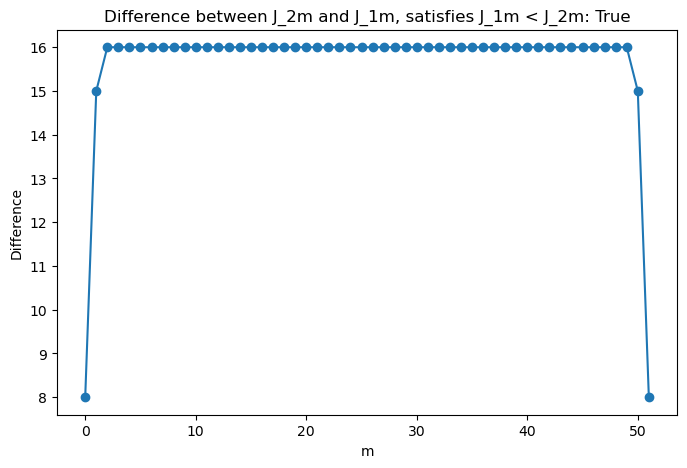

In [14]:

N = 364
b = 7
w = 16
M = int(np.ceil(N / b))

# Compute J_1m and J_2m
J_1m_values = np.maximum(0, np.minimum(np.arange(M) * b - w/2, N-b - w/2))# Shape: (M,)
print(J_1m_values)
J_2m_values = np.maximum(0, np.minimum(np.arange(M) * b + w/2, N-b))    # Shape: (M,)
print(J_2m_values)

# Compute the difference
difference = J_2m_values - J_1m_values

# Plot the difference
plt.figure(figsize=(8, 5))
plt.plot(range(M), difference, marker='o', linestyle='-', label='J_2m - J_1m')
plt.xlabel('m')
plt.ylabel('Difference')
plt.title(f'Difference between J_2m and J_1m, satisfies J_1m < J_2m: {~np.any(J_1m_values >= J_2m_values)}')
plt.show()

# Metrics
Mathematical formulation for discrete Wasserstein Distance, with $q$ being the quantiles:
$$
W_p(\mu_1, \mu_2) = \left( \int_0^1 \left| F_1^{-1}(q) - F_2^{-1}(q) \right|^p \, dq \right)^{\frac{1}{p}}
$$


In [15]:
class Metrics:

    @staticmethod
    def mse(test_item_series: pd.Series, bootstrap_samples: pd.Series) -> float:
        """
        Computes the Mean Squared Error (MSE) as decomposed into bias^2 and variance.
        
        Parameters:
        - test_item_series: The ground truth value for comparison (assumed seasonal demand sum).
        - bootstrap_samples: A Pandas Series of bootstrap sample estimates.
        
        Returns:
        - MSE value as a float.
        """
        season_demand = np.sum(test_item_series, axis=0)
        bias = (np.mean(bootstrap_samples) - season_demand) ** 2
        
        variance = np.var(bootstrap_samples, ddof=1)  # Using sample variance (ddof=1 for unbiased estimator)
        
        mse = bias + variance
        return mse
    
    @staticmethod
    def mape(test_item_series: pd.Series, bootstrap_samples: pd.Series) -> float:
        """
        Computes the Mean Absolute Percentage Error (MAPE) as a percentage value.
        """
        season_demand = np.sum(test_item_series, axis=0)
        return np.mean(np.abs(bootstrap_samples - season_demand) / season_demand) * 100

    @staticmethod
    def mae(test_item_series: pd.Series, bootstrap_samples: pd.Series) -> float:
        """
        Computes the Mean Absolute Error (MAE).
        """
        season_demand = np.sum(test_item_series, axis=0)
        return np.mean(np.abs(bootstrap_samples - season_demand))

    @staticmethod
    def discrete_wasserstein(dist1: pd.Series, dist2:pd.Series, p: int= 2) -> float:
        """
        Compute the p-Wasserstein distance between two discrete one dimensional distributions.
        own implementation bc wasserstein distance in stats package is only defined for the first order


        Parameters:
        - dist1: np.array, first distribution samples
        - dist2: np.array, second distribution samples
        - p: int, order of Wasserstein distance
        
        Returns:
        - Wasserstein-p distance (float)
        """
        dist1_sorted = np.sort(dist1)
        dist2_sorted = np.sort(dist2)

        return np.power(np.sum(np.abs(dist1_sorted - dist2_sorted) ** p) / len(dist1), 1 / p)

### Parameter Evaluation

In [16]:
from joblib import Parallel, delayed

In [17]:
class Evaluation:

    def __init__(self, input_data):
        self.input_data = input_data

    def single_evaluation(self, key: int):
        """
        helps to avoid waiting time in debugging
        """
        pass

    def full_evaluation(self, window_size, block_size, num_twins):
        """
        Perform a full evaluation over all test items.
        I could save time by fetching the data in one batch -> include twin item selection in a later step
        """
        results_list = [
            {
                "TEST_ITEM_COMMUNICATIONKEY": test_item,
                "window_size": window_size,
                "block_size": block_size,
                "num_twins": num_twins,
                "MSE": np.mean(Metrics.mse(
                    self.input_data.get_test_item(test_item),
                    Resampling.lb_bootstrap(self.input_data.get_twin_item(test_item, num_twins), window_size, block_size)
                ))
            }
            for test_item in self.input_data.TEST_ITEM_COMMUNICATIONKEYS
        ]

        return pd.DataFrame(results_list)

    def evaluate_parameter_grid(self, max_twin_num: int = 10, max_block_size: int = 30, max_window_size: int = 60):
        """
        Parameter Anzahl reduzieren?
        Sollten die Twins hier überhaupt berücksichtigt werden oder in einer 
        """
        block_sizes = np.arange(1, max_block_size + 1)
        window_size = np.arange(2, max_window_size +2 , 2)
        param_grid = [(w, b, max_twin_num) for w in window_size for b in block_sizes]

        results_list = []

        for params in tqdm(param_grid, desc="Grid Search Evaluation"):
            results_list.append(self.full_evaluation(*params))

        return pd.concat(results_list, ignore_index=True)

    def parallel_evaluate_parameter_grid(self, max_twin_num: int = 10, max_block_size: int = 30, max_window_size: int = 60):
        """
        Parameter Anzahl reduzieren?
        Sollten die Twins hier überhaupt berücksichtigt werden oder in einer 
        """
        block_sizes = np.arange(1, max_block_size + 1)
        window_size = np.arange(2, max_window_size +2 , 2)
        param_grid = [(w, b, max_twin_num) for w in window_size for b in block_sizes]

        #results_list = []

        #both mac book and my windows toaster have 8 cores, leave some idle to keep the system responsive, -1 for max speed
        results_list = Parallel(n_jobs=-1)(
            delayed(self.full_evaluation)(*params) for params in tqdm(param_grid, desc="Grid Search Evaluation")
        )

        return pd.concat(results_list, ignore_index=True)

In [18]:
evaluator = Evaluation(InputData())
results = evaluator.parallel_evaluate_parameter_grid()

KeyboardInterrupt: 

# Error Diagnosis

### 1. Optimierung der Parameter
- **Frage:** Was ist die beste Parameterkombination?

### 2. Identifikation von Ausreißern
- **Frage:** Welche Items sind die größten Ausreißer?

### 3. Bias-Analyse
- **Frage:** Haben wir allgemein einen positiven oder negativen Bias? (Test if correction factor might help)

### 4. Einfluss von Parametern auf Bias und Varianz
- **Frage:** Ändern sich Bias und Varianz mit den Parametern, insbesondere mit der Anzahl der Twins?

### 5. Vergleich mit Bootstrap
- **Frage:** Lohnt sich das im Vergleich zum einfachen Bootstrap?

### 6. Ausblick auf Performance-Änderungen
- **Frage:** Wie ändert sich die Performance, wenn die Beobachtungsperiode um 1 Jahr verschoben wird?
  - **Erwartung:** Der Einfluss des Trends wird erhöht.

In [ ]:
# read in results from results file
df_evalueation = pd.read_csv("results/evaluation_results.csv")

# Normality test
- clt is defined for iid data
- distributions moments must be finite?
- tune number of iteration until distribution is normal -> helps simplify methods of robust optimization

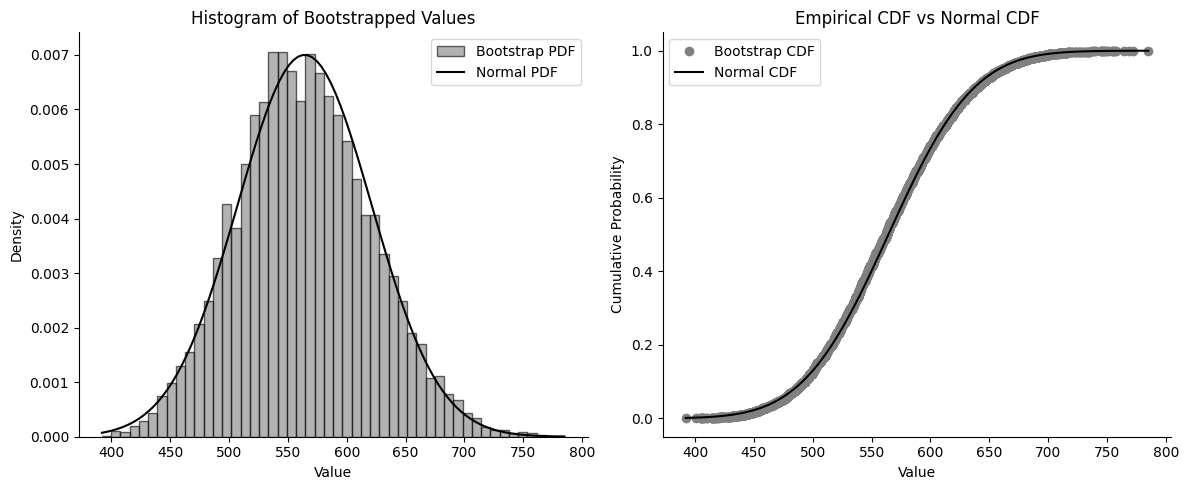

: 

: 

: 

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the histogram
ax1.hist(results_simple, bins=50, density=True, alpha=0.6, color='grey', edgecolor='black', label='Bootstrap PDF')
ax1.set_title('Histogram of Bootstrapped Values')
ax1.set_xlabel('Value')
ax1.set_ylabel('Density')

# Remove top and right spines for the histogram
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Calculate the normal PDF
x = np.linspace(min(results_simple), max(results_simple), 100)
normal_pdf = stats.norm.pdf(x, loc=np.mean(results_simple), scale=np.sqrt(np.var(results_simple, ddof = 1)))

# Plot the normal PDF
ax1.plot(x, normal_pdf, label='Normal PDF', color='black', linestyle='-')

# Plot the empirical CDF
data_sorted = np.sort(results_simple)
# Calculate the ECDF values
ecdf = np.arange(1, len(data_sorted) + 1) / len(data_sorted)
ax2.plot(data_sorted, ecdf, marker='o', linestyle='none', color='grey', label='Bootstrap CDF')

# Remove top and right spines for the CDF
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Calculate the normal CDF
normal_cdf = stats.norm.cdf(x, loc=np.mean(results_simple), scale=np.sqrt(np.var(results_simple, ddof = 1)))

# Plot the normal CDF
ax2.plot(x, normal_cdf, label='Normal CDF', color='black', linestyle='-')

ax2.set_title('Empirical CDF vs Normal CDF')
ax2.set_xlabel('Value')
ax2.set_ylabel('Cumulative Probability')

# Add legends
ax1.legend()
ax2.legend()

plt.tight_layout()
plt.savefig('plots/bootstrap_joint_distribution.svg')
plt.show()


In [ ]:
#H0: the data is normally distributed
#define alpha level
alpha = 0.05

In [ ]:
#generate integer samples from normal distribution
norm_samples = np.random.normal(50, 25, 100000).astype(int)

In [ ]:
norm_samples = np.random.normal(50, 5, 100000).astype(int)
_, p_value = stats.normaltest(norm_samples)
print(p_value)
if p_value > alpha:
    print("Fail to reject the null hypothesis: The data appears to be normally distributed.")
else:
    print("Reject the null hypothesis: The data does NOT appear to be normally distributed.")

0.7473996872939013
Fail to reject the null hypothesis: The data appears to be normally distributed.


In [ ]:
# Warning: for N > 5000, computed p-value may not be accurate.
_, p_value = stats.shapiro(results_simple)
print(p_value)
if p_value > alpha:
    print("Fail to reject the null hypothesis: The data appears to be normally distributed.")
else:
    print("Reject the null hypothesis: The data does not appear to be normally distributed.")

NameError: name 'results_simple' is not defined